In [1]:
from functools import partial

import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

#from nets import freeze_layers, get_model_from_name
from utils.callbacks import (ExponentDecayScheduler, LossHistory,
                             ModelCheckpoint)
from utils.dataloader import ClsDatasets
from utils.utils import get_classes
from utils.utils_fit import fit_one_epoch

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 获取数据集，测试集不变

In [35]:
class_names = ["no_sick", "sick"]
num_classes = 2

In [36]:
annotation_path = "path_txt//test_stable//train_val_two.txt"
val_split       = 0.2

with open(annotation_path, "r") as f:
    lines = f.readlines()

In [37]:
lines_0 = lines[:1050]
lines_1 = lines[1050:]

In [38]:
np.random.seed(10101)
np.random.shuffle(lines_0)
np.random.shuffle(lines_1)
np.random.seed(None)

In [39]:
lines = [lines_0, lines_1]

In [40]:
train_path = []
val_path = []

for i in range(2):
    line = lines[i]
    N = len(line)
    num_val     = int(N * val_split)
    num_train   = N - num_val
    for j in range(N):
        if j+1<=num_val:
            val_path.append(line[j])
        else:
            train_path.append(line[j])

In [41]:
num_train = len(train_path)
num_val = len(val_path)

In [42]:
np.random.seed(2022)
np.random.shuffle(train_path)
np.random.shuffle(val_path)
np.random.seed(None)

In [43]:
num_train

2671

In [44]:
num_val

667

In [45]:
annotation_path = "path_txt//test_stable//test_two.txt"

with open(annotation_path, "r") as f:
    test_path = f.readlines()

In [46]:
len(test_path)

832

# 获取数据的路径

In [34]:
class_names = ["no_sick", "sick"]
num_classes = 2

In [4]:
annotation_path = "path_txt/cls_two_class_test.txt"

with open(annotation_path, "r") as f:
    lines_test = f.readlines()

In [19]:
len(lines_test)

952

In [5]:
lines_test_0 = lines_test[:436]
lines_test_1 = lines_test[436:]

In [6]:
np.random.seed(10101)
np.random.shuffle(lines_test_0)
np.random.shuffle(lines_test_1)
np.random.seed(None)

In [7]:
annotation_path = "path_txt/cls_two_class_train.txt"
val_split       = 0.2

with open(annotation_path, "r") as f:
    lines = f.readlines()

In [8]:
len(lines)

4094

In [9]:
lines_0 = lines[:1752]
lines_1 = lines[1752:]

In [10]:
np.random.seed(10101)
np.random.shuffle(lines_0)
np.random.shuffle(lines_1)
np.random.seed(None)

In [11]:
lines = [lines_0+lines_test_0, lines_1+lines_test_1]

In [13]:
train_path = []
val_path = []
test_path = []

for i in range(2):
    line = lines[i]
    N = len(line)
    num_val     = int(N * val_split)
    num_train   = N - num_val
    for j in range(N):
        if j+1<=num_val:
            val_path.append(line[j])
        elif (num_val<j+1)and(j+1<=2*num_val):
            test_path.append(line[j])
        else:
            train_path.append(line[j])

In [14]:
num_train = len(train_path)
num_val = len(val_path)

In [15]:
num_train

3030

In [16]:
num_val

1008

In [18]:
len(test_path)

1008

In [17]:
np.random.seed(2022)
np.random.shuffle(train_path)
np.random.shuffle(val_path)
np.random.seed(None)

# 模型

In [3]:
from tensorflow.keras.layers import (Dense,Input,GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras import applications

def resnet101(input_shape=None):
    net = applications.ResNet101(include_top=False,input_shape=input_shape,weights=None)

    return net

def ResNet101(input_shape=[224,224,3],classes=4):
    img_input = Input(input_shape)

    x = resnet101(input_shape)(img_input)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256)(x)
    x = Dense(256)(x)
    x = Dense(classes,activation='softmax', name='fc1000')(x)
    x = Model(img_input, x, name='ResNet101')
    return x

In [2]:
model = ResNet101(input_shape=[224,224,3],classes=2)

In [3]:
#model.load_weights('D:\class_PR\classification-tf2-main\logs\with_dict-ep015-loss0.060-val_loss0.509.h5')
model.load_weights("weights/cls_2/cls_2-ep020-loss0.078-val_loss0.243.h5")
#model.load_weights('two_cls_w.h5')

In [26]:
for i in range(2):
    model.layers[i].trainable = True

# 回调函数

In [47]:
logging         = TensorBoard(log_dir = 'logs/')
checkpoint      = ModelCheckpoint('logs/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                                    monitor='val_loss', save_weights_only=True, save_best_only=False, period=5)
reduce_lr       = ExponentDecayScheduler(decay_rate = 0.95, verbose = 1)
early_stopping  = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
loss_history    = LossHistory('logs/')

In [48]:
batch_size      = 16
Lr              = 1e-5
Init_Epoch      = 0
Freeze_Epoch    = 0
Epoch           = 100
input_shape     = [224, 224]
num_workers     = 1

epoch_step          = num_train // batch_size
epoch_step_val      = num_val // batch_size

if epoch_step == 0 or epoch_step_val == 0:
    raise ValueError('数据集过小，无法进行训练，请扩充数据集。')
            
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))

Train on 2671 samples, val on 667 samples, with batch size 16.


# 训练集和验证集

In [49]:
train_dataloader    = ClsDatasets(train_path, input_shape, batch_size, num_classes, train = True)
val_dataloader      = ClsDatasets(val_path, input_shape, batch_size, num_classes, train = False)

# 训练模型

In [50]:
model.compile(loss = 'categorical_crossentropy',
                    optimizer = Adam(lr = Lr),
                    metrics = ['categorical_accuracy'])
            
model.fit_generator(
    generator           = train_dataloader,
    steps_per_epoch     = epoch_step,
    validation_data     = val_dataloader,
    validation_steps    = epoch_step_val,
    epochs              = Epoch,
    initial_epoch       = Init_Epoch,
    use_multiprocessing = True if num_workers > 1 else False,
    workers             = num_workers,
    callbacks           = [logging, checkpoint, reduce_lr, early_stopping, loss_history]
    #class_weight= cls_wt_dict
)

Epoch 1/100
 62/166 [==========>...................] - ETA: 1:34 - loss: 0.1259 - categorical_accuracy: 0.9587

KeyboardInterrupt: 

# 画混淆矩阵

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib import pyplot as plt
%matplotlib inline

# borrowed from scikit learn  这个是为了画混淆矩阵
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [51]:
val_for_test = ClsDatasets(test_path, input_shape, 1, num_classes, train = False)

x_val_for_test = []
y_val_for_test =[]

for x,y in val_for_test:
    x_val_for_test.append(x)
    y_val_for_test.append(y)

x_val_for_test = np.asarray(x_val_for_test)
y_val_for_test = np.asarray(y_val_for_test)

x_val_for_test = np.squeeze(x_val_for_test, 1)
y_val_for_test = np.squeeze(y_val_for_test, 1)

y_val_for_test_pred = model.predict(x_val_for_test)

Y_pred_val = np.argmax(y_val_for_test_pred,axis=1)
Y_actual_val = np.argmax(y_val_for_test,axis=1)

#plot_confusion_matrix(Y_actual_val, Y_pred_val, np.array(class_names))

Confusion matrix, without normalization
[[243  19]
 [ 15 555]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

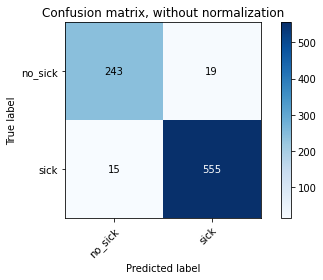

In [52]:
plot_confusion_matrix(Y_actual_val, Y_pred_val, np.array(class_names))

# 三分类

In [3]:
class_names_three = ["Retinopathy_grade_1", "Retinopathy_grade_2","Retinopathy_grade_3"]
num_classes_three = 3

In [4]:
annotation_path = "path_txt//test_stable/train_val_three.txt"

with open(annotation_path, "r") as f:
    lines_test_three = f.readlines()

In [5]:
lines_test_0_three = lines_test_three[:687]
lines_test_1_three = lines_test_three[687:1475]
lines_test_2_three = lines_test_three[1475:]

In [6]:
np.random.seed(10101)
np.random.shuffle(lines_test_0_three)
np.random.shuffle(lines_test_1_three)
np.random.shuffle(lines_test_2_three)
np.random.seed(None)

In [7]:
val_split       = 0.2

In [8]:
lines_three = [lines_test_0_three, lines_test_1_three, lines_test_2_three]

In [9]:
train_path_three = []
val_path_three = []
#test_path_three = []

for i in range(3):
    line = lines_three[i]
    N = len(line)
    num_val     = int(N * val_split)
    num_train   = N - num_val
    for j in range(N):
        if j+1<=num_val:
            val_path_three.append(line[j])
        else:
            train_path_three.append(line[j])

In [10]:
num_train = len(train_path_three)
num_val = len(val_path_three)

In [11]:
num_train

1832

In [12]:
num_val

456

In [13]:
np.random.seed(2022)
np.random.shuffle(train_path_three)
np.random.shuffle(val_path_three)
np.random.seed(None)

In [14]:
annotation_path = "path_txt//test_stable//test_three.txt"

with open(annotation_path, "r") as f:
    test_path_three = f.readlines()

In [15]:
len(test_path_three)

570

# 三分类模型

In [4]:
model_three = ResNet101(input_shape=[224,224,3],classes=3)

In [5]:
model_three.load_weights("weights/cls_3/cls_3-ep020-loss0.062-val_loss0.201.h5")

# 训练

In [20]:
logging         = TensorBoard(log_dir = 'logs/')
checkpoint      = ModelCheckpoint('logs/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                                    monitor='val_loss', save_weights_only=True, save_best_only=False, period=5)
reduce_lr       = ExponentDecayScheduler(decay_rate = 0.95, verbose = 1)
early_stopping  = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
loss_history    = LossHistory('logs/')

In [21]:
batch_size      = 16
Lr              = 1e-4
Init_Epoch      = 0
Epoch           = 100
input_shape     = [224, 224]
num_workers     = 1

epoch_step          = num_train // batch_size
epoch_step_val      = num_val // batch_size

if epoch_step == 0 or epoch_step_val == 0:
    raise ValueError('数据集过小，无法进行训练，请扩充数据集。')
            
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))

Train on 1832 samples, val on 456 samples, with batch size 16.


In [22]:
train_dataloader_three    = ClsDatasets(train_path_three, input_shape, batch_size, num_classes_three, train = True)
val_dataloader_three      = ClsDatasets(val_path_three, input_shape, batch_size, num_classes_three, train = False)

In [23]:
model_three.compile(loss = 'categorical_crossentropy',
                    optimizer = Adam(lr = Lr),
                    metrics = ['categorical_accuracy'])
            
model_three.fit_generator(
    generator           = train_dataloader_three,
    steps_per_epoch     = epoch_step,
    validation_data     = val_dataloader_three,
    validation_steps    = epoch_step_val,
    epochs              = Epoch,
    initial_epoch       = Init_Epoch,
    use_multiprocessing = True if num_workers > 1 else False,
    workers             = num_workers,
    callbacks           = [logging, checkpoint, reduce_lr, early_stopping, loss_history]
    #class_weight= cls_wt_dict
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
  1/114 [..............................] - ETA: 0s - loss: 0.9508 - categorical_accuracy: 0.4375WARNING:tensorflow:From d:\miniconda\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
114/114 [==============================] - 156s 1s/step - loss: 0.9626 - categorical_accuracy: 0.5844 - val_loss: 1.2247 - val_categorical_accuracy: 0.3415
Epoch 2/100
114/114 [==============================] - 104s 910ms/step - loss: 0.6521 - categorical_accuracy: 0.6990 - val_loss: 1.1248 - val_categorical_accuracy: 0.3594
Epoch 3/100
114/114 [==============================] - 79s 695ms/step - loss: 0.5801 - categorical_accuracy: 0.7505 - val_loss: 1.1350 - val_categorical_accuracy: 0.3281
Epoch 4/100
114/114 [============================

KeyboardInterrupt: 

# 画三分类的混淆矩阵

In [26]:
val_for_test = ClsDatasets(test_path_three, input_shape, 1, num_classes_three, train = False)

x_val_for_test = []
y_val_for_test =[]

for x,y in val_for_test:
    x_val_for_test.append(x)
    y_val_for_test.append(y)

x_val_for_test = np.asarray(x_val_for_test)
y_val_for_test = np.asarray(y_val_for_test)

x_val_for_test = np.squeeze(x_val_for_test, 1)
y_val_for_test = np.squeeze(y_val_for_test, 1)

y_val_for_test_pred = model_three.predict(x_val_for_test)

Y_pred_val = np.argmax(y_val_for_test_pred,axis=1)
Y_actual_val = np.argmax(y_val_for_test,axis=1)

#plot_confusion_matrix(Y_actual_val, Y_pred_val, np.array(class_names))

Confusion matrix, without normalization
[[158  13   0]
 [  8 183   5]
 [  0  13 190]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

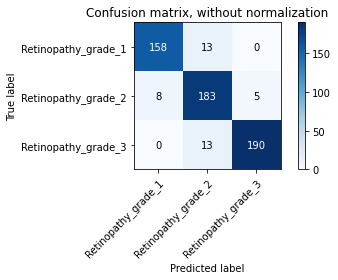

In [29]:
plot_confusion_matrix(Y_actual_val, Y_pred_val, np.array(class_names_three))

# 使用两个模型一起预测

In [7]:
annotation_path = "path_txt//test_stable//test.txt"

with open(annotation_path, "r") as f:
    test_path = f.readlines()

In [8]:
model = ResNet101(input_shape=[224,224,3],classes=2)

In [9]:
model.load_weights("weights/cls_2/cls_2-ep020-loss0.078-val_loss0.243.h5")

In [10]:
num_classes_final=4

In [12]:
input_shape = [224, 224]
val_for_test = ClsDatasets(test_path, input_shape, 1, num_classes_final, train = False)

x_val_for_test = []
y_val_for_test =[]

for x,y in val_for_test:
    x_val_for_test.append(x)
    y_val_for_test.append(y)

x_val_for_test = np.asarray(x_val_for_test)
y_val_for_test = np.asarray(y_val_for_test)

x_val_for_test = np.squeeze(x_val_for_test, 1)
y_val_for_test = np.squeeze(y_val_for_test, 1)

In [13]:
two_cls = model.predict(x_val_for_test)

In [14]:
two_cls = np.argmax(two_cls,axis=1)

In [15]:
#two_cls

In [16]:
three_cls = model_three.predict(x_val_for_test)

In [17]:
three_cls = np.argmax(three_cls,axis=1)

In [18]:
three_cls.shape

(832,)

In [19]:
y_val_for_test_pred = []
for i,x in enumerate(two_cls):
    if x==0:
        y_val_for_test_pred.append(0)
    else:
        y_val_for_test_pred.append(three_cls[i]+1)

In [20]:
Y_pred_val =  np.asarray(y_val_for_test_pred) 
        
#Y_pred_val = np.argmax(y_val_for_test_pred,axis=1)
Y_actual_val = np.argmax(y_val_for_test,axis=1)

In [21]:
class_names_final = ["Retinopathy_grade_0","Retinopathy_grade_1", "Retinopathy_grade_2","Retinopathy_grade_3"]

Confusion matrix, without normalization
[[251   5   6   0]
 [ 14 150   7   0]
 [  8  12 172   4]
 [  2   1  12 188]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

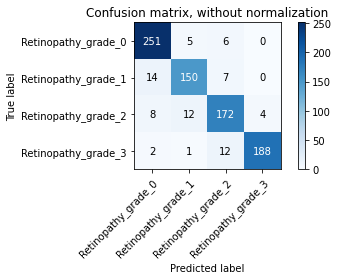

In [22]:
plot_confusion_matrix(Y_actual_val, Y_pred_val, np.array(class_names_final))